# Cowboy results for X

***Add notes about your experiment here.***

*NB* requires a kernel with pycorn. 

If you don't have one, you can use 'shifty'

To get shifty as a kernal option, log onto the digs and run:
/software/containers/scripts/registerapptainerkernel.sh /software/containers/shifty.sif

In [22]:
import glob
from datetime import date

today = date.today().strftime("%Y%m%d")[2:]
print(f"Today: {today}")
# import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import sys, os

sys.path.append("/net/software/lab/cowboy")
from wetlab_utils import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

sns.set_theme(
    context="talk",
    palette="colorblind",
    style="ticks",
    rc={"axes.spines.right": False, "axes.spines.top": False},
)

Today: 240808


## ECHO cloning


`eblocks_plates`: dictionary containing paths to `.xlsx` files from IDT eBlocks order(s).
- If the IDT order spreadsheet is passed unmodified, and a set of vectors is indicated, then the ECHO transfer protocol will include cloning of every eBlock into every vector.
- If more complex cloning combinatorics is desired, include a `Vector` column in the spreadhseet to specify the entry vector for each eBlock. 

***If not using the ECHO generator function, `echo_df` should at a minimum contain the following columns:***
   - `Name`: the name of your design.
   - `Destination Well`: the destination well of the transfer.
   - `Destination Plate Name`: 96w expression plate identifier.
   - `eblock`: the eBlock sequence.
   - `Vector`: the GGA entry vector ID, e.g. `LM0627`.
   - `n_chains`: if your proteins are oligomers, this is the oligomeric state. not necessary if all your proteins are monomers

In [23]:
echo_df = pd.read_csv(
    "2024_07_25_e139_e_coli_BsaI_df.csv"
) # This path should be the path to the df file outputted by johnbercow
echo_df["Vector"] = "LM0627" # LM0627, LM1371,
echo_df = echo_df.rename(columns={"Sequence": "eblock"})
echo_df = echo_df.rename(columns={"plate_id": "Destination Plate Name"})
echo_df = echo_df.rename(columns={"Well Position": "Destination Well"})
echo_df.head()
echo_df

,design_name,eblock,length_eblock,readin_order,design_aa_seq,LM0627_cloned_plasmid_seq,ORF_from_LM0627,exp_aa_seq_from_LM0627,idt_score,order_name,is_frag,is_hto,design_id,position,Destination Plate Name,Destination Well,Name,Vector
0,plt_00037_93170_refined_1_clean_5_38,atactacggtctcaaggaGCGTTTAAAGAAGCGATTAGCCTGTTTA...,515,0,AFKEAISLFKSKVTTSDYNSWVQLAKKTDNPQAVLDAGNKHTSYLD...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagcgtttaaagaagcgattagcctgtttaaaagcaaag...,MSGAFKEAISLFKSKVTTSDYNSWVQLAKKTDNPQAVLDAGNKHTS...,0,e139,False,False,lig0001,1_A1,1,A1,lig0001__A1__e139.1__plt_00037_93170_refined_1...,LM0627
1,plt_00038_112587_refined_1_clean_4_49,atactacggtctcaaggaAGCAGCGCGCGTGTGACCCTGCGCGCGT...,479,1,SSARVTLRAYSNDPEVVGELVQRMSCEELAGFLRAKAEAGERVAIV...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaagcagcgcgcgtgtgaccctgcgcgcgtattctaacg...,MSGSSARVTLRAYSNDPEVVGELVQRMSCEELAGFLRAKAEAGERV...,0,e139,False,False,lig0002,1_A2,1,B1,lig0002__A2__e139.1__plt_00038_112587_refined_...,LM0627
2,plt_00038_203810_refined_0_clean_6_46,atactacggtctcaaggaAAACGCCTGACCCTGCTGTTTACCCAGA...,464,2,KRLTLLFTQSDVPKEIIDKANEANIRVYITANPSDKNYENNHRKAK...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaaaacgcctgaccctgctgtttacccagagcgatgtgc...,MSGKRLTLLFTQSDVPKEIIDKANEANIRVYITANPSDKNYENNHR...,0,e139,False,False,lig0003,1_A3,1,A2,lig0003__A3__e139.1__plt_00038_203810_refined_...,LM0627
3,plt_00038_49234_refined_1_clean_1_6,atactacggtctcaaggaGTGGATATTGCGATTGGTGTTGCGGTGG...,392,3,VDIAIGVAVGNTPEELARNREKVLELAKEYNVELDELAEAPSCEAV...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagtggatattgcgattggtgttgcggtgggcaacaccc...,MSGVDIAIGVAVGNTPEELARNREKVLELAKEYNVELDELAEAPSC...,0,e139,False,False,lig0004,1_A4,1,B2,lig0004__A4__e139.1__plt_00038_49234_refined_1...,LM0627
4,plt_00038_112287_refined_1_clean_5_97,atactacggtctcaaggaGTTGAAGAAATCGTGGAATCCGTGGTGC...,479,4,VEEIVESVVRLAAKLGAIILIPVNRADMFDPEWQALQQLIEEIAAR...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggagttgaagaaatcgtggaatccgtggtgcgtctggcgg...,MSGVEEIVESVVRLAAKLGAIILIPVNRADMFDPEWQALQQLIEEI...,0,e139,False,False,lig0005,1_A5,1,A3,lig0005__A5__e139.1__plt_00038_112287_refined_...,LM0627
5,plt_00038_5154_refined_1_clean_8_95,atactacggtctcaaggaAAGAAAATCATGCTGGTGCTGAACTTTG...,488,5,KKIMLVLNFDNDNPELVKAILAVVAKTGLLELIAVFANSEEAAKRL...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaaagaaaatcatgctggtgctgaactttgataacgata...,MSGKKIMLVLNFDNDNPELVKAILAVVAKTGLLELIAVFANSEEAA...,0,e139,False,False,lig0006,1_A6,1,B3,lig0006__A6__e139.1__plt_00038_5154_refined_1_...,LM0627
6,plt_00038_46883_refined_0_clean_8_81,atactacggtctcaaggaATGCGCCGCCTGTTTCTGGTGCAGGTGG...,530,6,MRRLFLVQVVGLNEDDPEAQLAEARKVAERAGIPFGGVVDTPEAAA...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgcgccgcctgtttctggtgcaggtggtgggcctga...,MSGMRRLFLVQVVGLNEDDPEAQLAEARKVAERAGIPFGGVVDTPE...,0,e139,False,False,lig0007,1_A7,1,A4,lig0007__A7__e139.1__plt_00038_46883_refined_0...,LM0627
7,plt_00038_119211_refined_0_clean_5_32,atactacggtctcaaggaATGCTGGGCGATTTTGAACTGGATACCG...,515,7,MLGDFELDTAVGLAQAAREAGAGALVVPTNDPADAERLAARLEEAG...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgctgggcgattttgaactggataccgcggtgggtt...,MSGMLGDFELDTAVGLAQAAREAGAGALVVPTNDPADAERLAARLE...,0,e139,False,False,lig0008,1_A8,1,B4,lig0008__A8__e139.1__plt_00038_119211_refined_...,LM0627
8,plt_00037_216899_refined_0_clean_1_40,atactacggtctcaaggaGGCTTAGCGGAACGTGTTCGTGCCTTAG...,467,8,GLAERVRALGDVGAATLYFTDLRNHADPRLAREHAQSVVDAFRAAL...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaggcttagcggaacgtgttcgtgccttaggtgatgtgg...,MSGGLAERVRALGDVGAATLYFTDLRNHADPRLAREHAQSVVDAFR...,0,e139,False,False,lig0009,1_A9,1,A5,lig0009__A9__e139.1__plt_00037_216899_refined_...,LM0627
9,plt_00038_149976_refined_1_clean_2_85,atactacggtctcaaggaATGAAAATTAACGTGTTTCTGCCGAGCA...,533,9,MKINVFLPSIPTSEEGVDAFRNIISLVNTIAPVSKVFISVNKESLE...,cagtagtaggttgaggccgttgagcaccgccgccgcaaggaatggt...,atgtcaggaatgaaaattaacgtgtttctgccgagcattccgacca...,MSGMKINVFLPSIPTSE

## Expression/purification parameters
- `oligomers`: whether or not your designs are oligomers (if `True`, a column `n_chains` needs to be specified in `echo_df`).
- `culture_vol`: culture volume, formated as a string `AxB` where `B` is the volume of one culture (in mL), and `A` the number of consolidated cultures.
- `culture_time`: time between inocculation and harvest, in hours.
- `culture_temp`: temperature during growth/expression, in degree Celsius.
- `sec_column`: column used for SEC, e.g. `S75_5-150`, `S200_5-150`,`S75_10_300`,etc.
- `sec_buffer`: buffer used for SEC.
- `sec_buffer_pH`: the pH of the SEC buffer. 
- `sec_instrument`: the instrument used for SEC. Must be either `akta` or `hplc`.
- `sec_calibration`: instrument and column-specific calibration file (`.json` format)
        - Calibrations are kept in /net/software/lab/cowboy/calibrations/
- `sec_traces`: dictionary of lists of paths to exported SEC traces. 
    - `AKTA` data structure should be `/path_to_your_run/*.zip`. The list should contain paths to the individual `.zip` files.
    - `HPLC` data structure should be `/path_to_your_run/trace_folders/*.CSV`. The list should contain paths to the individual *trace folders*, NOT the individual `.CSV` files. The folder containing the individual trace folders should also contain the `fractions.csv` file containing the mapping between traces and fractions.

In [24]:
oligomers = False  # if this is true, you need an n_chains column if your df that says the oligomeric state
culture_vol = "4x1"
culture_time = 20
culture_temp = 37
sec_column = "S75_5-150"
sec_buffer = "PBS"
sec_buffer_pH = 8.0
sec_instrument = "hplc"
sec_calibration = "/net/software/lab/cowboy/calibrations/231123_S75_5-150_HPLC.json"
sec_traces = {
    1: glob.glob("/net/expdata/HPLC/_HAL9000/Stacey/20240808_ach_ligase_35/*")
}

print(f"Number of SEC traces: {np.sum([len(v) for v in sec_traces.values()])}")
print("\n".join([f"> {k}: {len(v)}" for k, v in sec_traces.items()]))

Number of SEC traces: 36
> 1: 36


### Add information to dataframe

If you are cloning into non-standard entry vectors, change the path to their `.fa` files.

In [25]:
# Clone.
echo_df["plasmid_seq"] = echo_df.apply(
    clone,
    path_to_vectors="/software/lab/johnbercow/entry_vectors/",
    axis=1,
)
echo_df["ORF"] = echo_df.apply(coding_seq, axis=1)

# Protparam.
echo_df = protparam(echo_df, oligomers, sec_buffer_pH)

# Expression parameters.
echo_df["culture_vol"] = float(culture_vol.split("x")[0]) * float(
    culture_vol.split("x")[1]
)
echo_df["culture_time"] = culture_time
echo_df["culture_temp"] = culture_temp

# Purification parameters.
echo_df["sec_instrument"] = sec_instrument
echo_df["sec_column"] = sec_column
echo_df["sec_buffer"] = sec_buffer

# OPTIONAL: define a category for later comparisons (e.g. designs made using different methods).
echo_df["category"] = echo_df["Destination Plate Name"].astype(str)
echo_df.category.value_counts()

category
1    35
Name: count, dtype: int64

### Process SEC chromatograms

*NB*: 205 nm may be used instead of 280 nm for protein quantification, however this option is poorly validated.

In [26]:
# %%capture

wl = 280  # wavelength used for all downstream data processing.

parsed_chromatograms = {}
for run, traces in sec_traces.items():
    parsed_chromatograms[run] = parse_chromatograms(traces, instrument=sec_instrument)

sec_data = {}
for run, parsed_chroma in parsed_chromatograms.items():
    sec_data[run] = process_sec_data(parsed_chroma, wavelength=wl)

### Map traces to wells

***CAUTION:*** make sure to validate your mapping (both wells AND destination plates), especially if you had to e.g. restart you SEC run (indices may have shifted!). 

Check that the size of the resulting dataframe matches the number of samples you injected.

In [27]:
sec_df = pd.DataFrame()
for run, sec_d in sec_data.items():

    w96 = [
        str(p) + "_" + r + str(c)
        for p in range(1, 10)
        for r in "ABCDEFGH"
        for c in range(1, 13)
    ]

    if sec_instrument == "akta":

        akta2well = {i + 1: w for i, w in enumerate(w96)}
        sec_d["well_id"] = sec_d["trace_id"].map(akta2well)
        sec_d["Destination Plate Name"] = sec_d["well_id"].apply(
            lambda x: int(x.split("_")[0])
        )
        sec_d["Destination Well"] = sec_d["well_id"].apply(lambda x: x.split("_")[1])

    if sec_instrument == "hplc":

        drawer2plate = {
            "D1F": 1,
            "D1B": 2,
            "D2F": 3,
            "D2B": 4,
            "D3F": 5,
            "D3B": 6,
            "D4F": 7,
            "D4B": 8,
        }
        sec_d["Destination Plate Name"] = sec_d["trace_id"].apply(
            lambda x: drawer2plate[x.split("-")[0]]
        )
        sec_d["Destination Well"] = sec_d["trace_id"].apply(lambda x: x.split("-")[1])
        sec_d["well_id"] = (
            sec_d["Destination Plate Name"].astype(str)
            + "_"
            + sec_d["Destination Well"]
        )

    sec_df = pd.concat([sec_df, sec_d])

df = echo_df.merge(
    sec_df,
    left_on=["Destination Plate Name", "Destination Well"],
    right_on=["Destination Plate Name", "Destination Well"],
).reset_index(drop=True)

len(df)

35

### Add yields and calibrated results to dataframe

In [28]:
df = yields(df)
df, CI95, CI99 = calibrated_results(df, sec_calibration)
int_df = df.copy()

## Results overview

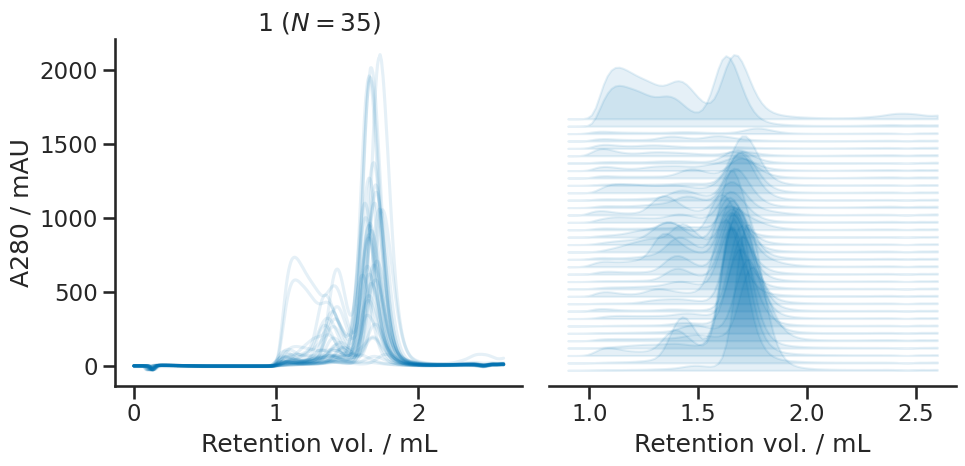

In [29]:
for cat, sel in df.groupby("category"):

    sel.reset_index(inplace=True)

    # Cluster chromatograms.
    vol_light = np.vstack(sel.loc[:, "vol_light"].to_numpy())
    Abs_light = np.vstack(sel.loc[:, "Abs_light"].to_numpy())
    clustered_idx = hierarchy.dendrogram(
        hierarchy.linkage(Abs_light, method="average", optimal_ordering=True),
        no_plot=True,
    )[
        "leaves"
    ]  # 'leaves' are the re-ordered indices

    # Plot.
    delta = np.max([np.max(x) for x in sel.Abs.to_numpy()]) / 20
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    for i, r in sel.iterrows():
        ax[0].plot(r.vol, r.Abs, color="C0", alpha=0.1)
        ax[1].fill_between(
            x=vol_light[clustered_idx[i]],
            y1=Abs_light[clustered_idx[i]] + i * delta,
            y2=i * delta,
            color="C0",
            alpha=0.1,
            zorder=i,
        )

    ax[0].set(xlabel="Retention vol. / mL", ylabel=f"A280 / mAU")
    ax[1].set(xlabel="Retention vol. / mL", yticks=[])
    ax[1].spines["left"].set_visible(False)
    ax[0].set(title=f"{cat} ($N = {len(sel)}$)")
    plt.tight_layout()
    #plt.savefig(f"all_sec_traces_{cat}.png", dpi=300)
    plt.show()

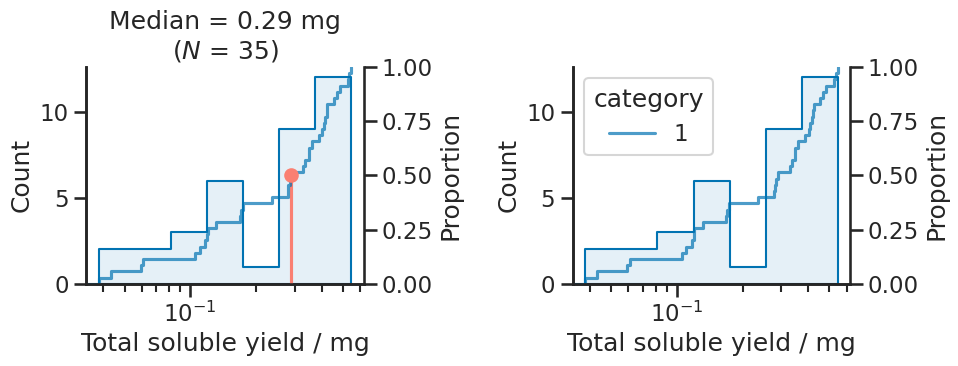

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

sns.histplot(
    data=df,
    x="tot_yield",
    stat="count",
    ax=ax[0],
    log_scale=True,
    element="step",
    alpha=0.1,
)

ax0 = ax[0].twinx()
ax0.vlines(df.tot_yield.median(), 0, 0.5, color="salmon")
ax0.scatter(df.tot_yield.median(), 0.5, color="salmon", zorder=10)
sns.ecdfplot(data=df, x="tot_yield", alpha=0.7, ax=ax0)
ax[0].spines["right"].set_visible(True)
ax[0].set_xlabel("Total soluble yield / mg")
ax[0].set_title(f'Median = {df["tot_yield"].median():.2f} mg\n($N$ = {len(df)})')

sns.histplot(
    data=df,
    x="tot_yield",
    hue="category",
    stat="count",
    ax=ax[1],
    log_scale=True,
    element="step",
    alpha=0.1,
    legend=False,
)

sns.ecdfplot(
    data=df,
    x="tot_yield",
    hue="category",
    ax=ax[1].twinx(),
    legend=True,
    alpha=0.7,
)

ax[1].spines["right"].set_visible(True)
ax[1].set_xlabel("Total soluble yield / mg")

plt.tight_layout()
#plt.savefig("tot_soluble_yields.png", dpi=300)
plt.show()

## Calibrated results

/scratch/srgerb/13039679/ipykernel_4108284/1454383492.py:64: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, label="Tot. yield / mg")


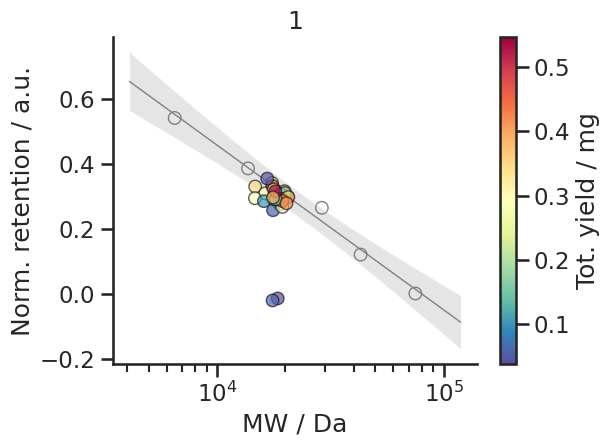

In [31]:
# Get SEC column calibration parameters.
with open(sec_calibration, "r") as f:
    sec_cal = json.load(f)

Vo, Vc = sec_cal["Vo"], sec_cal["Vc"]
intercept, slope = sec_cal["intercept"], sec_cal["slope"]
all_mws = np.hstack([sec_cal["log10mw"], np.log10(df["MW"].to_numpy())])
xs = np.linspace(all_mws.min() - 0.2, all_mws.max() + 0.2, 100)


def Vel2MW(Vel):
    return 10 ** ((((Vel - Vo) / (Vc - Vo)) - intercept) / slope)


for c, sel in df.groupby("category"):

    # Plot calibration curve and CI.
    plt.scatter(
        [10**x for x in sec_cal["log10mw"]],
        sec_cal["Kav"],
        edgecolor="grey",
        linewidth=1,
        color="None",
        alpha=1,
    )

    plt.plot(
        10**xs,
        intercept + slope * xs,
        color="grey",
        linewidth=1,
    )

    plt.fill_between(
        10**xs,
        CI95[0],
        CI95[1],
        color="grey",
        alpha=0.2,
        edgecolor=None,
    )

    # Plot data.
    norm = plt.Normalize(sel.tot_yield.min(), sel.tot_yield.max())
    sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)

    ax = sns.scatterplot(
        data=sel,
        x="MW",
        y="main_peak_norm_retention",
        hue="tot_yield",
        palette="Spectral_r",
        zorder=10,
        edgecolor="k",
        linewidth=1,
        alpha=0.7,
    )

    plt.xscale("log")
    plt.xlabel("MW / Da")
    plt.ylabel("Norm. retention / a.u.")

    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Tot. yield / mg")
    plt.title(c)
    plt.tight_layout()
    #plt.savefig(f"{c}_against_calibration.png", dpi=300)
    plt.show()

/scratch/srgerb/13039679/ipykernel_4108284/513887159.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, label="Tot. yield / mg")


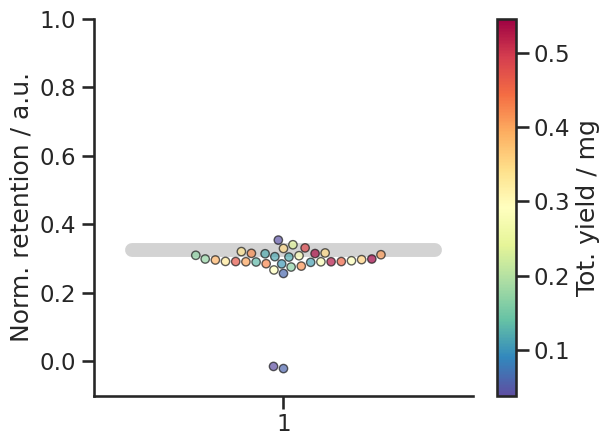

In [32]:
norm = plt.Normalize(df.tot_yield.min(), df.tot_yield.max())
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)

sns.boxplot(
    data=df,
    x="category",
    y="expected_norm_retention",
    zorder=0,
    medianprops={"visible": True, "color": "lightgrey", "ls": "-", "lw": 10},
    whiskerprops={"visible": False},
    showfliers=False,
    showbox=False,
    showcaps=False,
)

ax = sns.swarmplot(
    data=df,
    x="category",
    y="main_peak_norm_retention",
    hue="tot_yield",
    palette="Spectral_r",
    alpha=0.7,
    edgecolor="k",
    linewidth=1,
    size=6,
)

ax.get_legend().remove()
ax.figure.colorbar(sm, label="Tot. yield / mg")
ax.set(ylim=[-0.1, 1], xlabel="", ylabel="Norm. retention / a.u.")
plt.tight_layout()
#plt.savefig("norm_retention_by_category.png", dpi=300)
plt.show()

## Peaks distribution

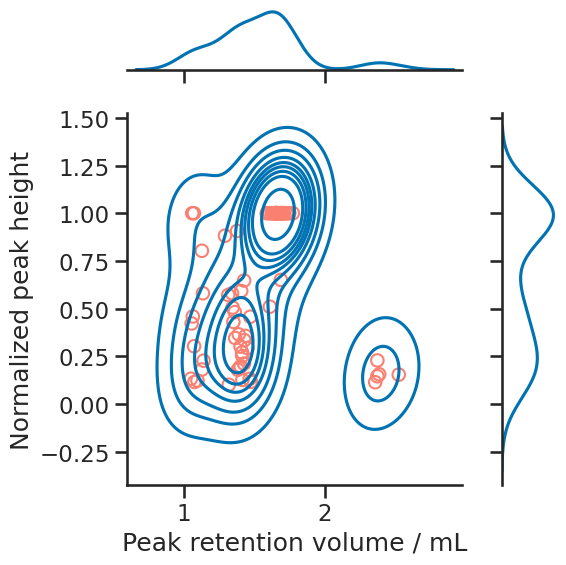

In [33]:
xs = np.hstack(df.peaks.to_list())
ys = np.hstack(df.peak_heights.to_list())
g = sns.jointplot(
    x=xs,
    y=ys,
    kind="kde",
    ratio=4,
)
g.ax_joint.scatter(xs, ys, facecolors="none", edgecolor="salmon")
g.ax_joint.set_xlabel("Peak retention volume / mL")
g.ax_joint.set_ylabel("Normalized peak height")
plt.tight_layout()
#plt.savefig("peaks_distribution.png", dpi=300)
plt.show()

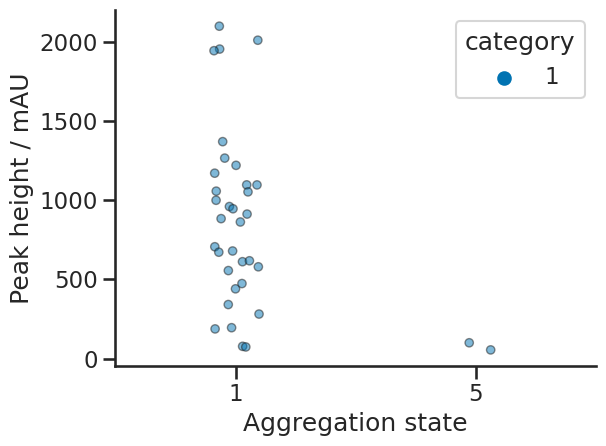

In [34]:
sns.stripplot(
    data=df.sort_values(by="main_peak_agg_state"),
    x="main_peak_agg_state",
    y="main_peak_height",
    hue="category",
    alpha=0.5,
    edgecolor="k",
    linewidth=1,
    size=6,
    dodge=True,
)

plt.xlabel("Aggregation state")
plt.ylabel("Peak height / mAU")
plt.tight_layout()
#plt.savefig("aggregation_states.png", dpi=300)
plt.show()

## Per-well results

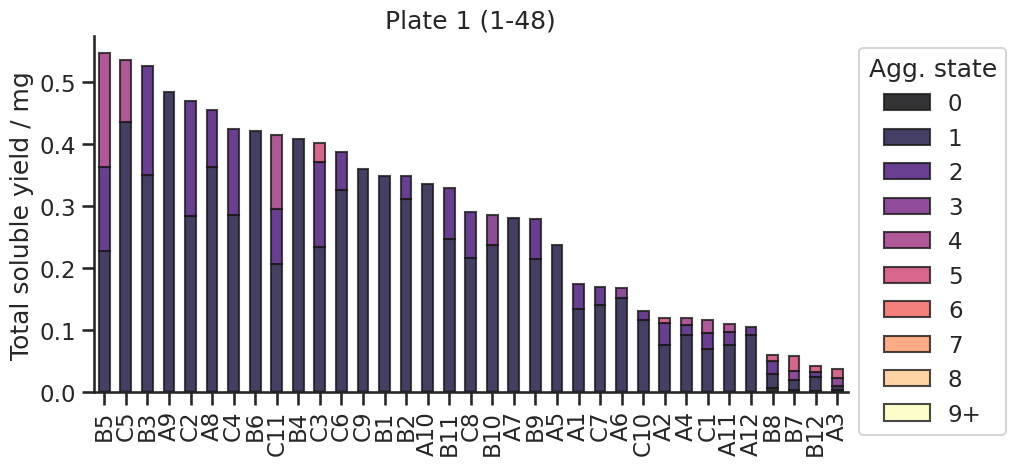

In [35]:
for plate, sel in df.groupby("Destination Plate Name"):

    states = [str(i) for i in range(9)] + ["9+"]

    agg_df = pd.DataFrame(
        index=sel["Destination Well"].to_list(),
        columns=states,
    )

    agg_df = agg_df.merge(
        sel[["tot_yield", "Destination Well"]],
        left_index=True,
        right_on="Destination Well",
    ).set_index("Destination Well", drop=True)

    agg_df.fillna(0, inplace=True)

    for i, r in sel.iterrows():
        agg_states = [round(Vel2MW(v) / r.protomer_MW) for v in r.peaks]
        proportions = r.tot_yield * r.peak_heights / r.peak_heights.sum()

        for agg_st, prop in zip(agg_states, proportions):

            if agg_st < 9:
                agg_df.loc[r["Destination Well"], str(agg_st)] += prop

            else:
                agg_df.loc[r["Destination Well"], "9+"] += prop

    agg_df.sort_values(
        by=["tot_yield"] + states,
        ascending=False,
        inplace=True,
    )

    n_subplots = np.ceil(len(agg_df) / 48).astype(int)
    fig, ax = plt.subplots(
        nrows=n_subplots,
        figsize=(len(agg_df) / n_subplots * 0.3, 5 * n_subplots),
        sharey=True,
    )

    if n_subplots == 1:
        ax = [ax]

    for i in range(n_subplots):
        agg_df.iloc[48 * i : 48 * (i + 1)][states].plot(
            ax=ax[i],
            kind="bar",
            stacked=True,
            edgecolor="k",
            alpha=0.80,
            cmap="magma",
        )

        ax[i].legend(bbox_to_anchor=(1, 1), title="Agg. state")
        ax[i].set(xlabel="", ylabel="Total soluble yield / mg")
        ax[i].set_title(f"Plate {plate} ({48*i+1}-{48*(i+1)})")
    plt.tight_layout()
    #plt.savefig(f"plate_{plate}_agg_per_well.png", dpi=300)
    plt.show()

## Pool fractions

- Choose the number of fraction to pool with `n_fractions`. Only adjacent fractions will be picked.
    - The tolerance (in mL) for what qualifies as adjacent can be specified with `adjacency`.

<!-- -->
- Choose the fraction picking logic with `how`:
    - `largest` will pick the fraction with the largest integral.
    - `nearest` will pick the fraction containing the *peak* nearest to the expected elution volume.

<!-- -->
- Use `manual_edits` if you want to overwrite the fractions that are automatically picked.


In [36]:
manual_edits = np.array([
    ['well_id', ['fraction1', 'fraction2', ]],
        # ["1_B2", ["1-P1-E1"]],
        # ["1_A3", ["1-P1-A21"]],
        # ["1_A6", ["1-P1-B8"]],
        # ["1_C2", ["1-P1-H16"]],
        # ["1_C4", ["1-P1-H3"]],
        # ["1_C10", ["1-P1-J13", "1-P1-J14"]],
    ], dtype=object,)

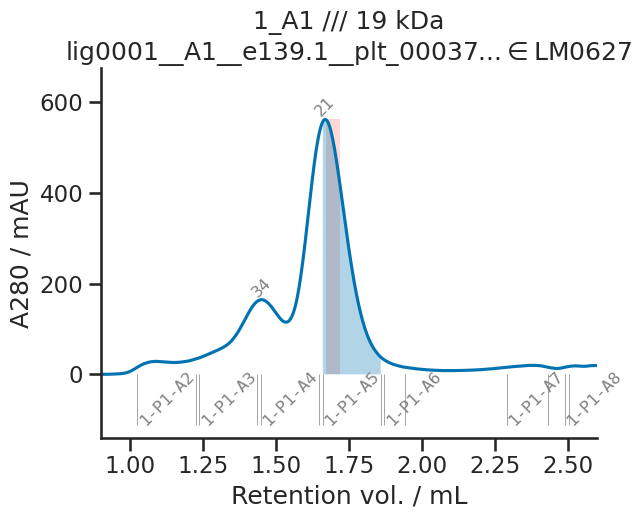

Next best fraction:
['1_A1', ['1-P1-A4']],


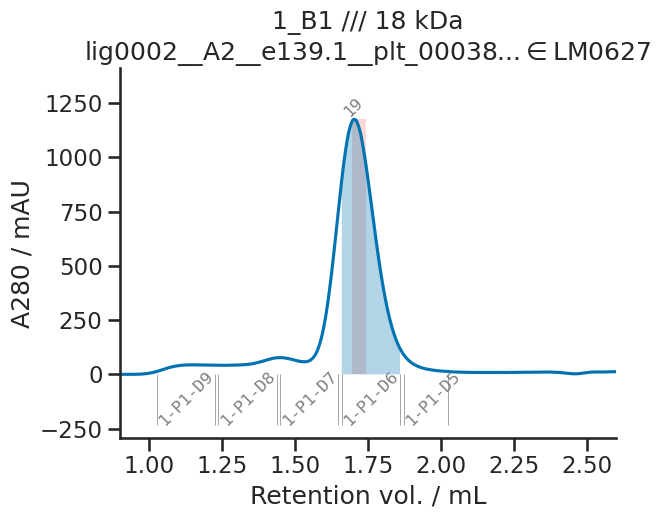

Next best fraction:
['1_B1', ['1-P1-D7']],


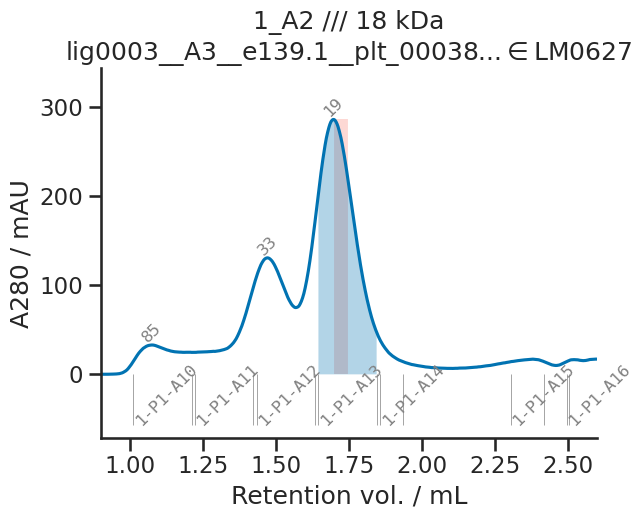

Next best fraction:
['1_A2', ['1-P1-A12']],


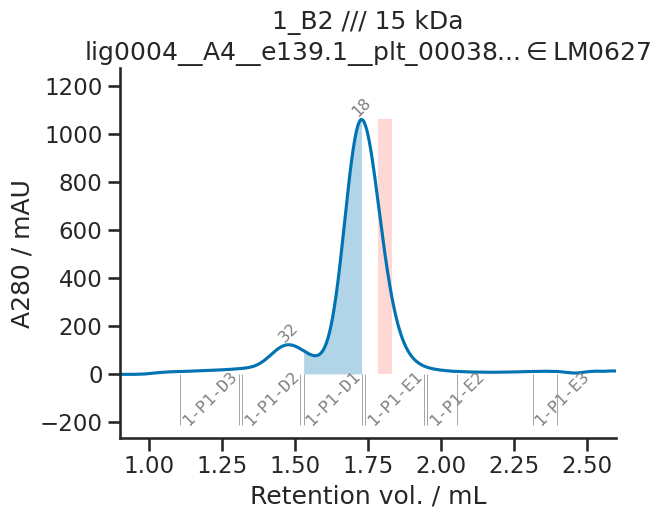

Next best fraction:
['1_B2', ['1-P1-E1']],


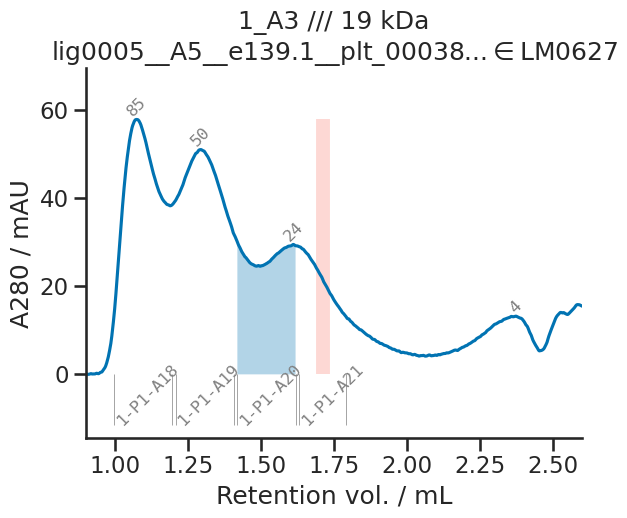

Next best fraction:
['1_A3', ['1-P1-A18']],


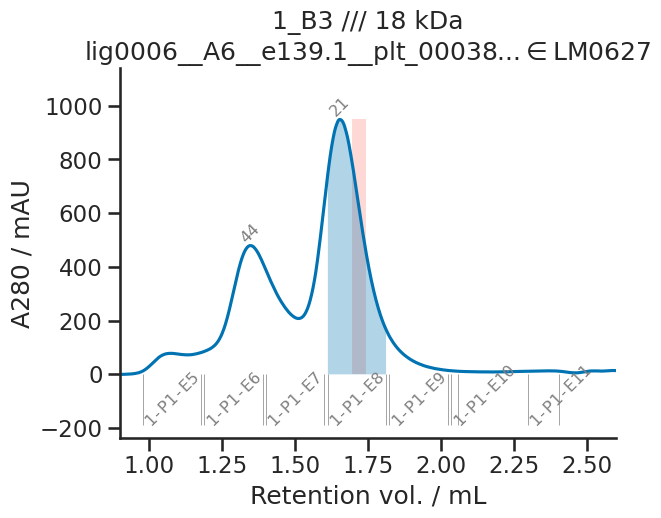

Next best fraction:
['1_B3', ['1-P1-E7']],


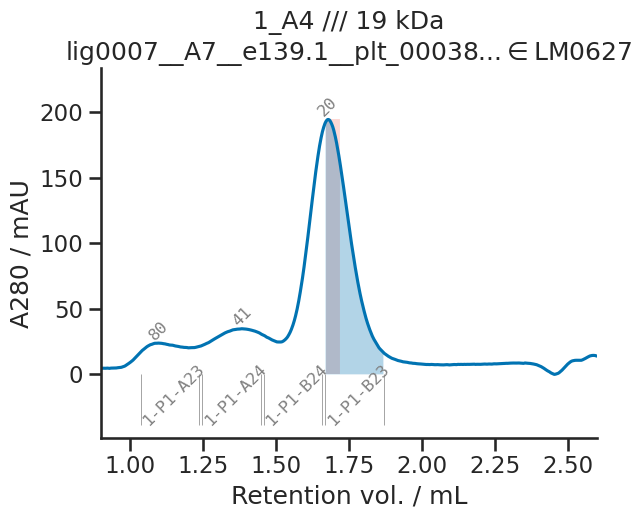

Next best fraction:
['1_A4', ['1-P1-B24']],


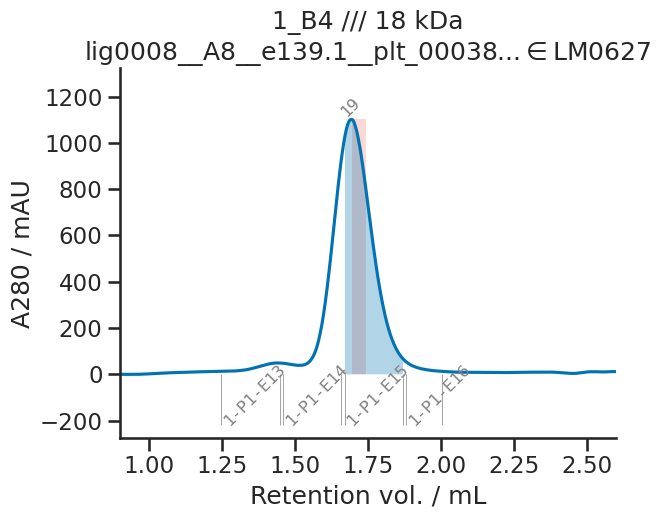

Next best fraction:
['1_B4', ['1-P1-E14']],


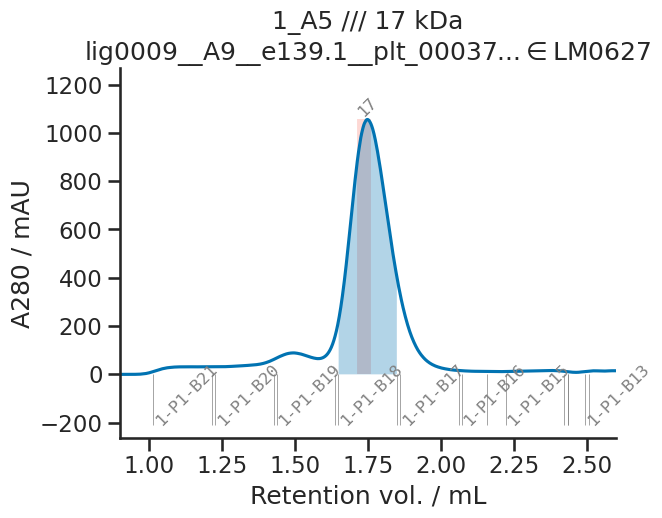

Next best fraction:
['1_A5', ['1-P1-B17']],


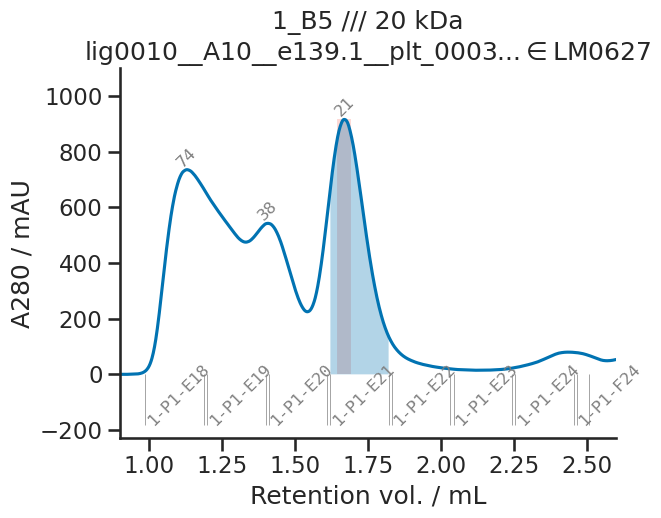

Next best fraction:
['1_B5', ['1-P1-E19']],


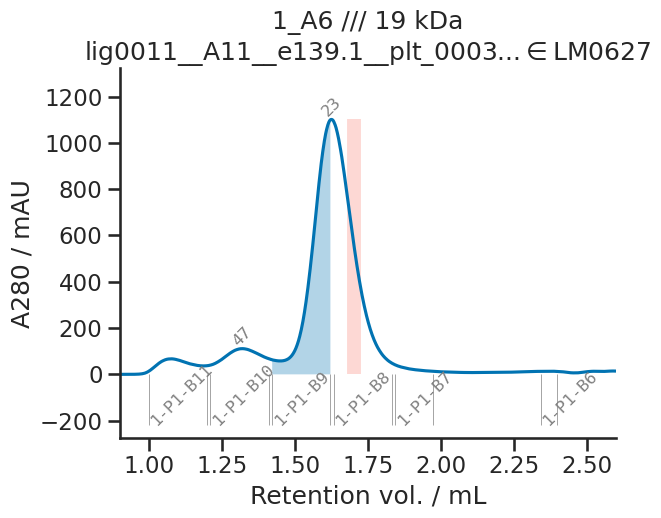

Next best fraction:
['1_A6', ['1-P1-B8']],


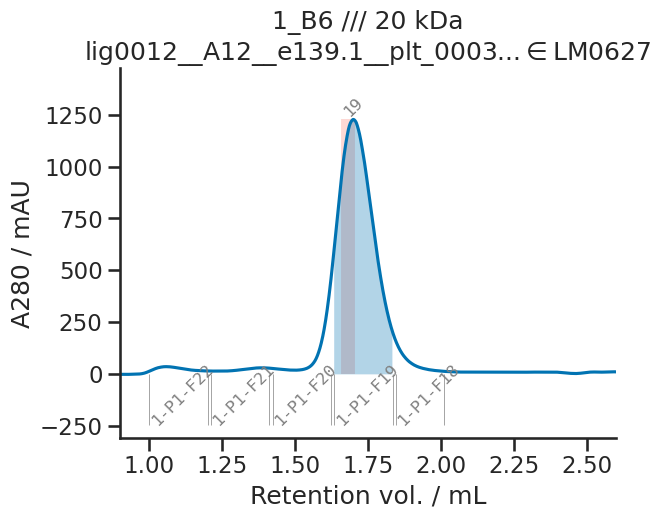

Next best fraction:
['1_B6', ['1-P1-F20']],


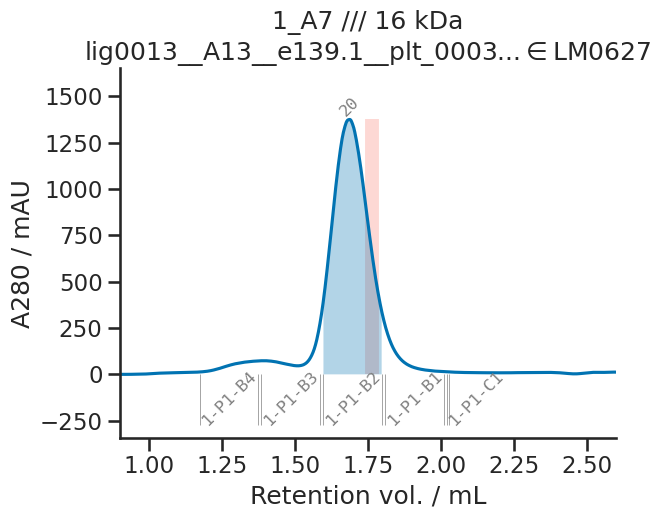

Next best fraction:
['1_A7', ['1-P1-B3']],


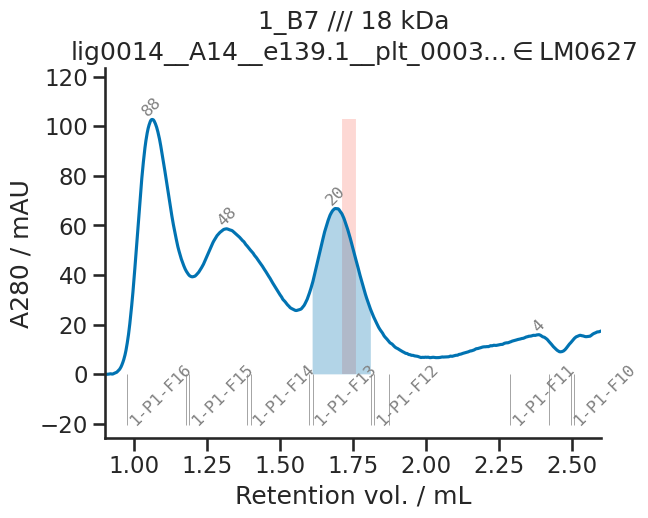

Next best fraction:
['1_B7', ['1-P1-F16']],


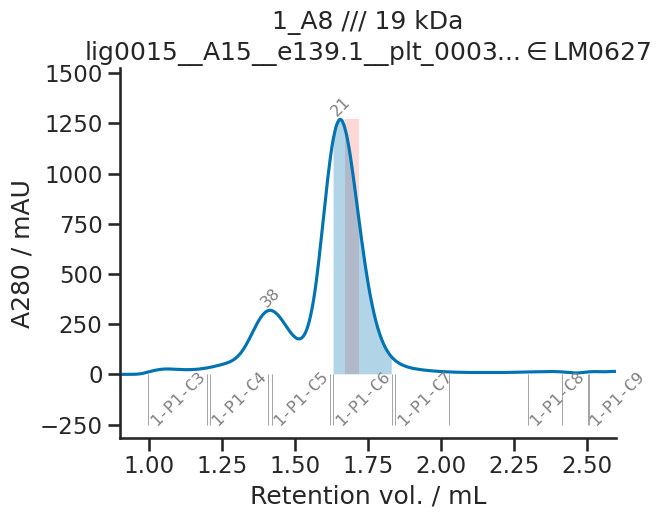

Next best fraction:
['1_A8', ['1-P1-C5']],


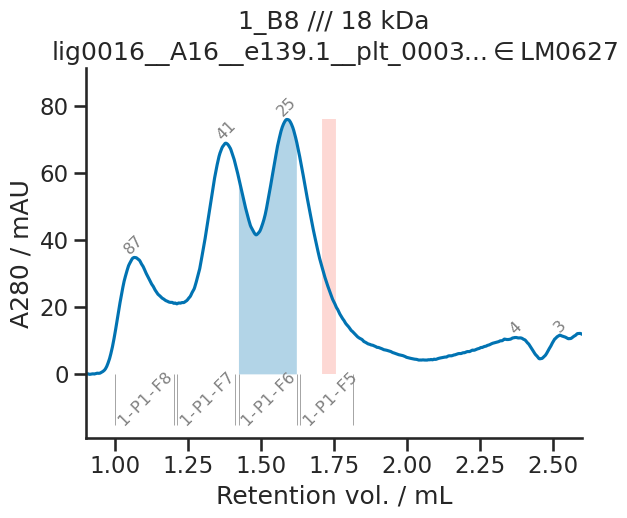

Next best fraction:
['1_B8', ['1-P1-F7']],


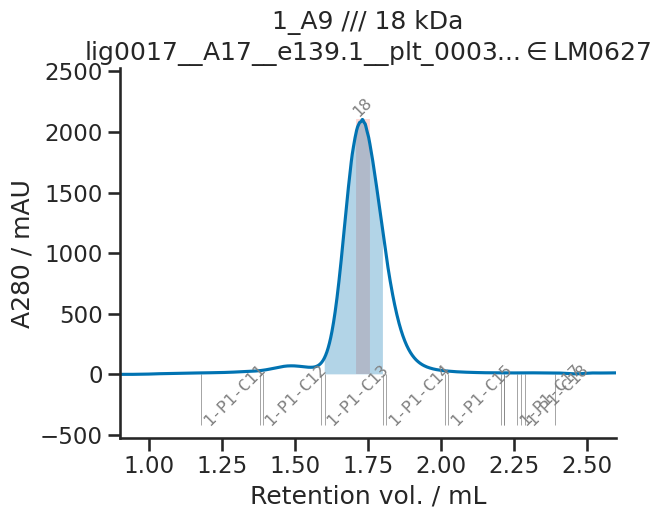

Next best fraction:
['1_A9', ['1-P1-C14']],


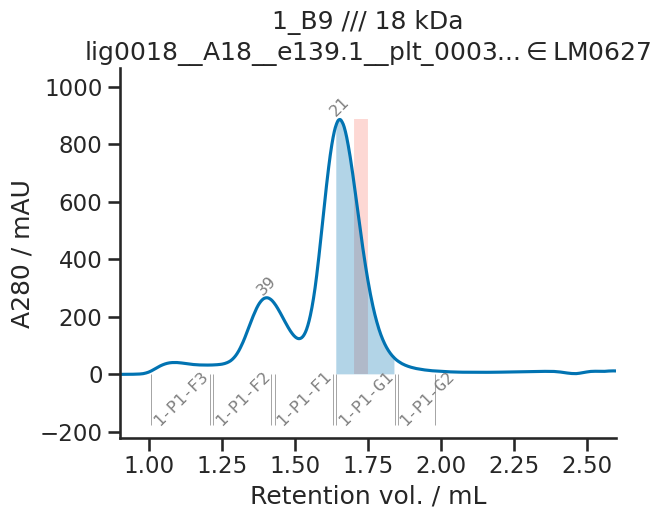

Next best fraction:
['1_B9', ['1-P1-F1']],


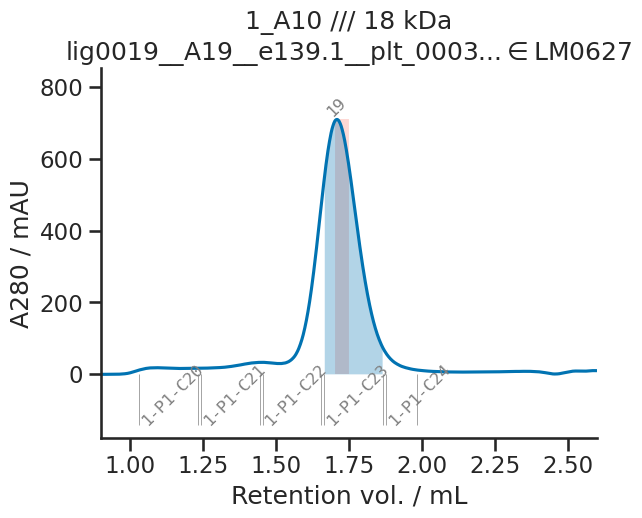

Next best fraction:
['1_A10', ['1-P1-C22']],


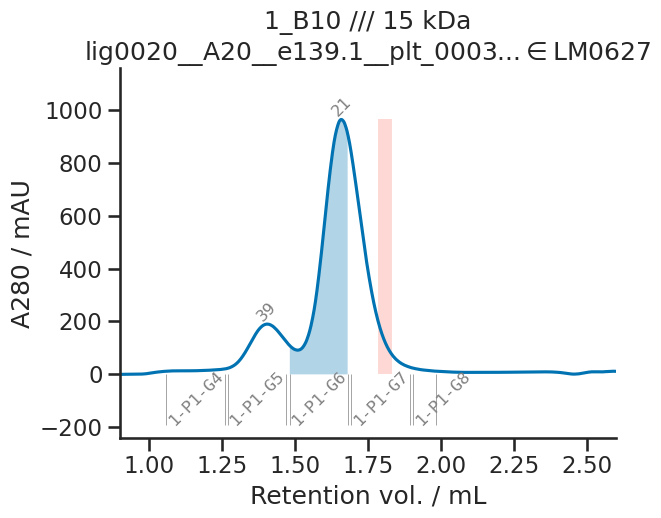

Next best fraction:
['1_B10', ['1-P1-G7']],


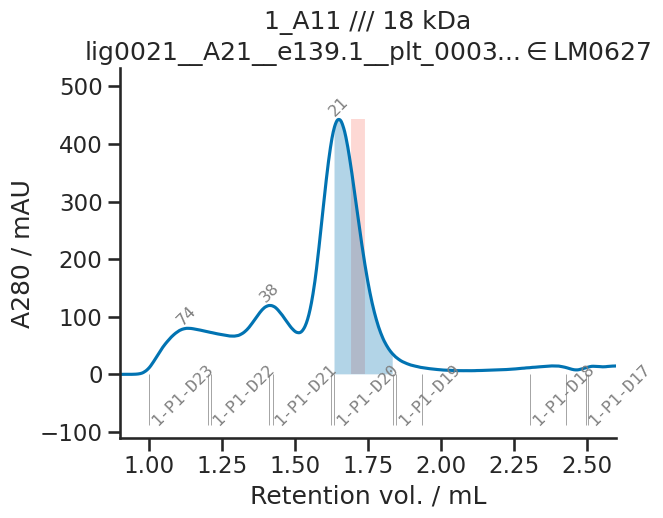

Next best fraction:
['1_A11', ['1-P1-D21']],


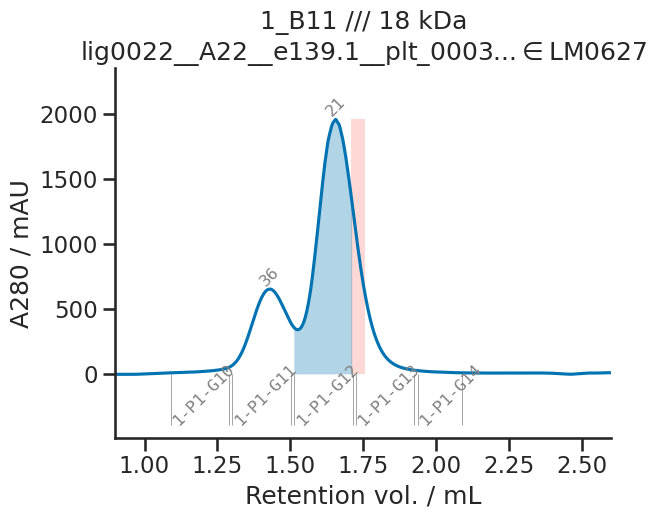

Next best fraction:
['1_B11', ['1-P1-G11']],


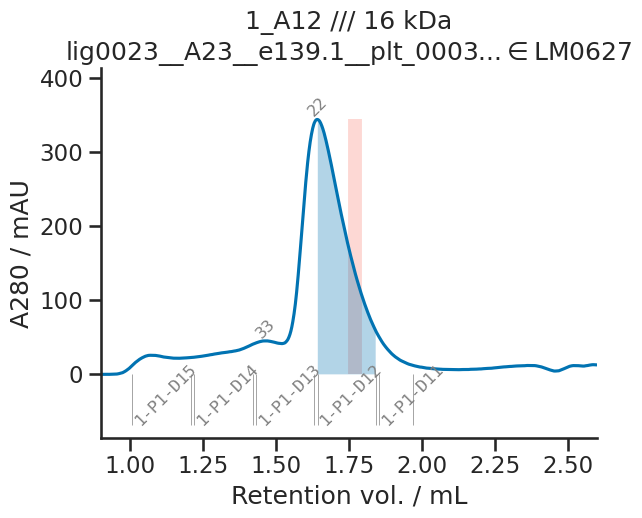

Next best fraction:
['1_A12', ['1-P1-D13']],


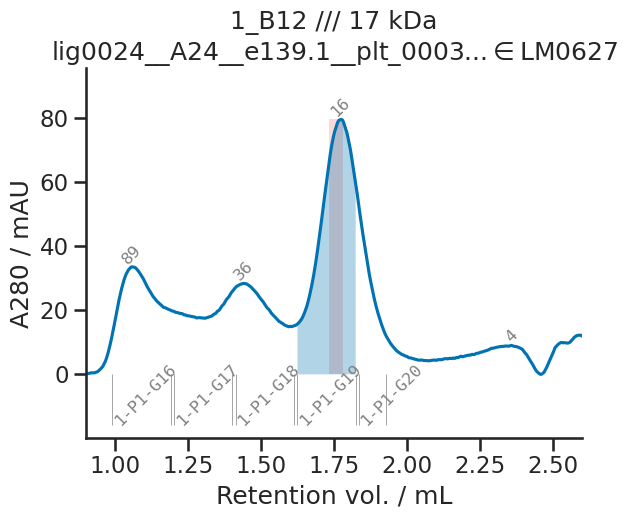

Next best fraction:
['1_B12', ['1-P1-G16']],


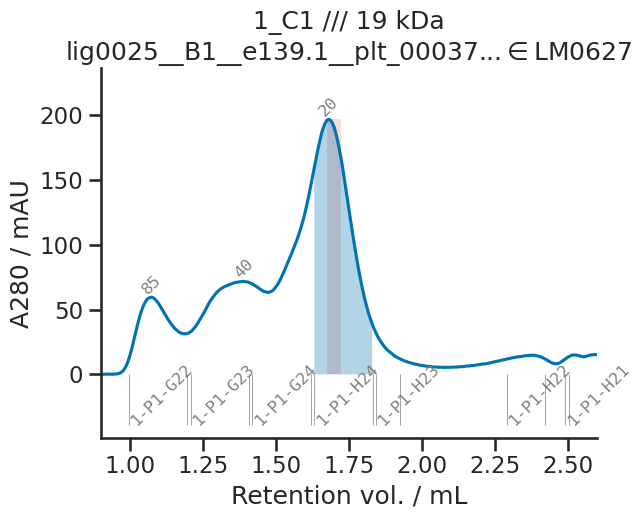

Next best fraction:
['1_C1', ['1-P1-G24']],


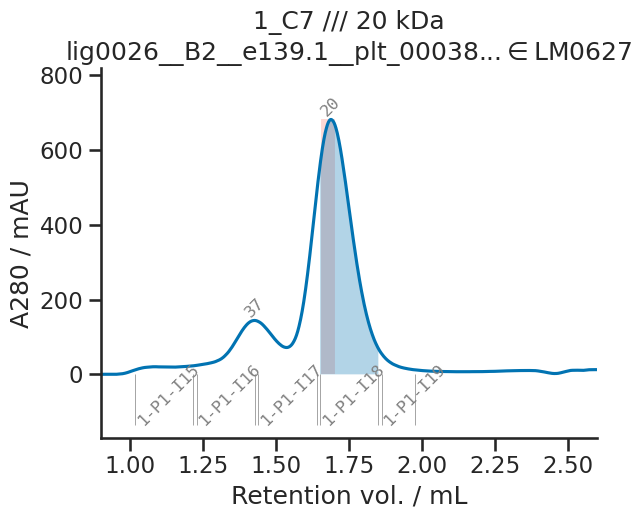

Next best fraction:
['1_C7', ['1-P1-I17']],


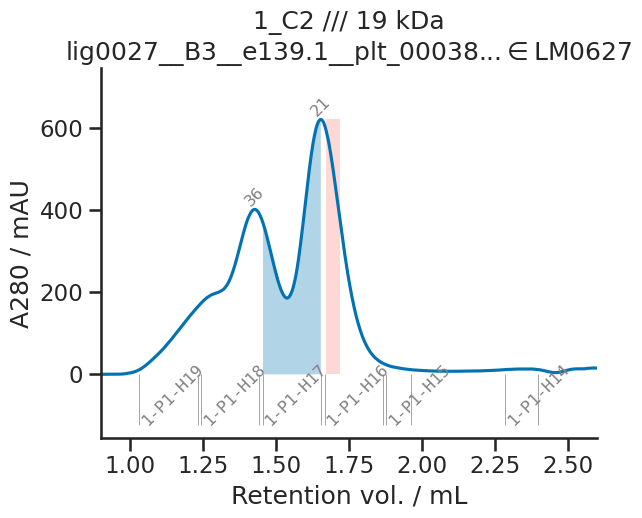

Next best fraction:
['1_C2', ['1-P1-H18']],


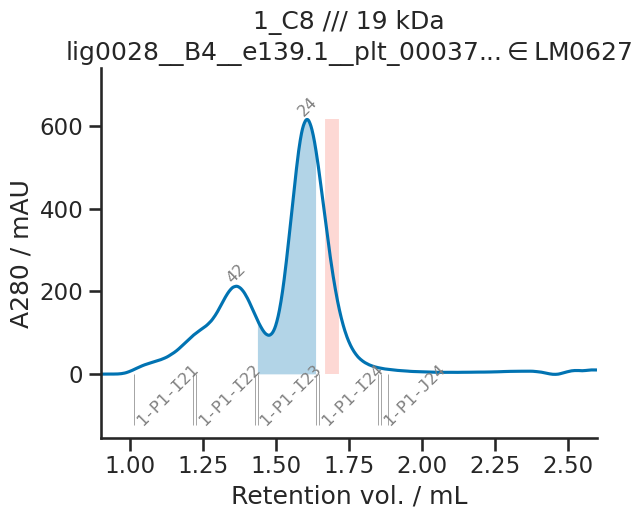

Next best fraction:
['1_C8', ['1-P1-I22']],


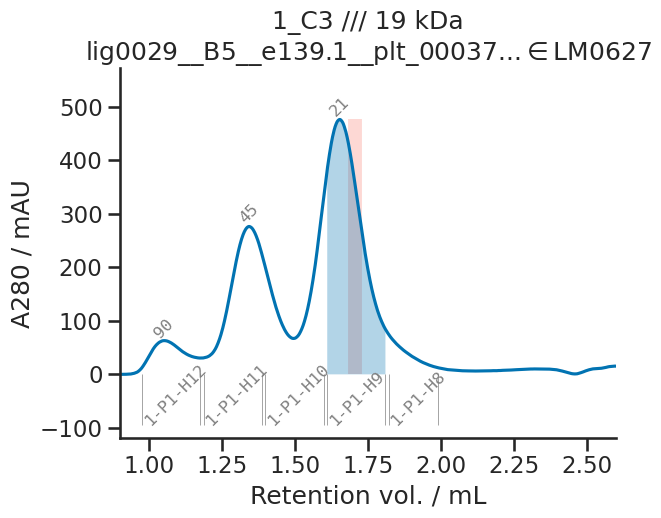

Next best fraction:
['1_C3', ['1-P1-H11']],


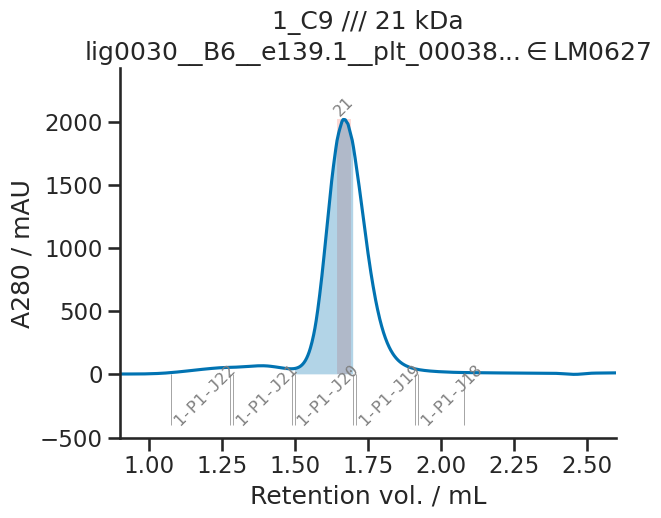

Next best fraction:
['1_C9', ['1-P1-J19']],


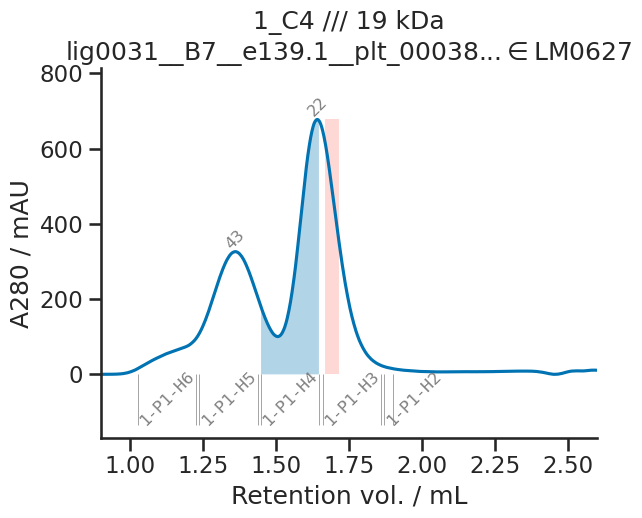

Next best fraction:
['1_C4', ['1-P1-H5']],


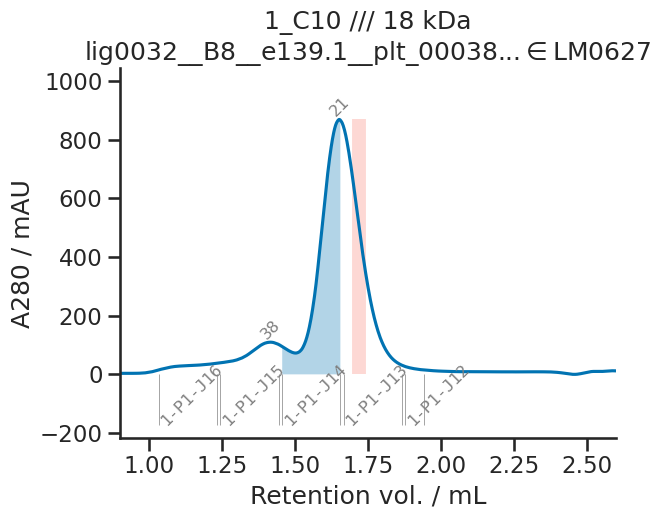

Next best fraction:
['1_C10', ['1-P1-J13']],


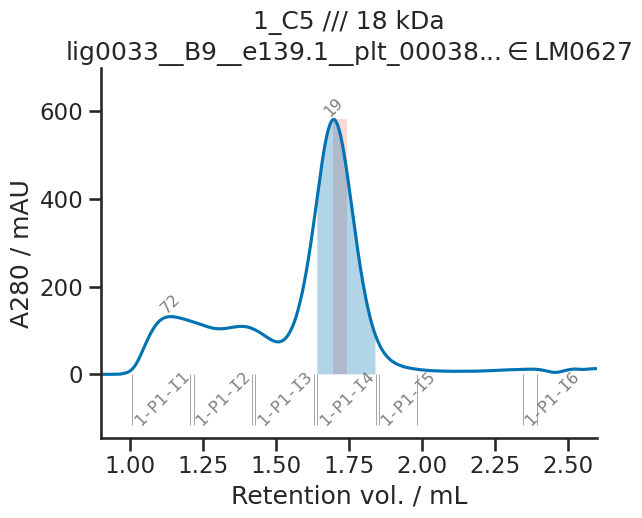

Next best fraction:
['1_C5', ['1-P1-I3']],


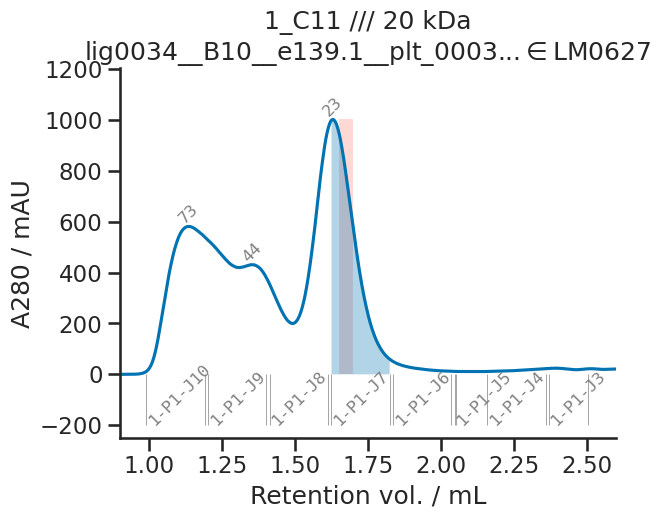

Next best fraction:
['1_C11', ['1-P1-J9']],


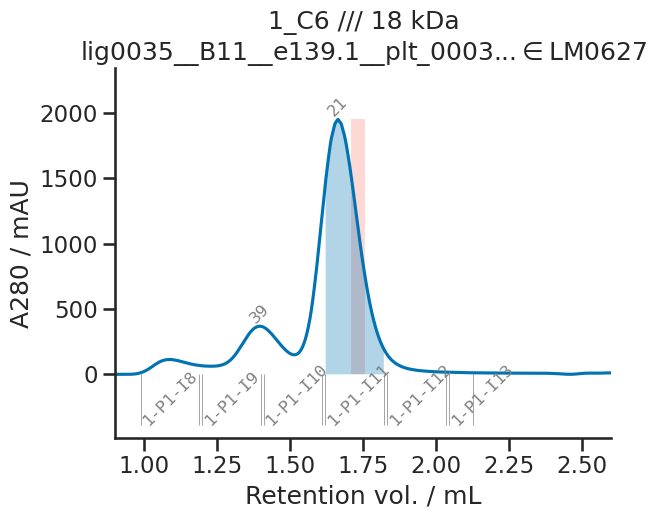

Next best fraction:
['1_C6', ['1-P1-I10']],


In [37]:
pooled_df = pd.DataFrame(
    columns=[
        "pooled_fractions",
        "pooled_frac_vol",
        "pooled_vol",
        "pooled_integral",
        "pooled_peak_Abs",
        "pooled_peak_vol",
    ]
)

for w, r in df.set_index("well_id").iterrows():
    select_fractions(
        w,
        r,
        pooled_df,
        manual_edits,
        Vel2MW,
        wl,
        n_fractions=1,
        how="nearest",
        adjacency=0.025,
    )

35


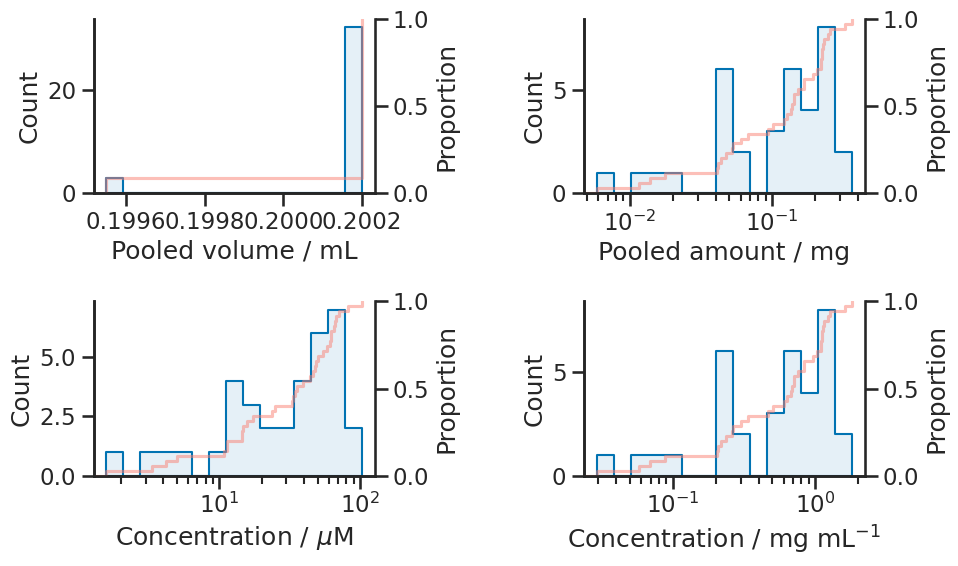

In [38]:
df = int_df.merge(pooled_df, left_on="well_id", right_index=True)

print(len(df))

df["conc_uM"] = (
    1e3 * df["pooled_integral"] / (df["pooled_vol"] * df["e280"] * df["path_length"])
)
df["conc_mgmL"] = (
    1e-3 * df["pooled_integral"] / (df["pooled_vol"] * df["OD280"] * df["path_length"])
)
df["pooled_mg"] = df["conc_mgmL"] * df["pooled_vol"]
df["pooled_peak_estimated_MW"] = df["pooled_peak_vol"].apply(Vel2MW)
df["pooled_peak_agg_state"] = round(
    df["pooled_peak_estimated_MW"] / df["protomer_MW"]
).astype(int)
df["pooled_is_main"] = df["main_peak"] == df["pooled_peak_vol"]

# Plot pooled statistics.
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
ax = ax.reshape(-1)

for i, (k, v) in enumerate(
    {
        "pooled_vol": "Pooled volume / mL",
        "pooled_mg": "Pooled amount / mg",
        "conc_uM": "Concentration / $\mu$M",
        "conc_mgmL": "Concentration / mg mL$^{-1}$",
    }.items()
):

    sns.histplot(
        df[k],
        ax=ax[i],
        element="step",
        bins=15,
        alpha=0.1,
        log_scale=False if "vol" in k else True,
    )
    sns.ecdfplot(df[k], ax=ax[i].twinx(), alpha=0.5, color="salmon")
    ax[i].spines["right"].set_visible(True)
    ax[i].set(xlabel=v)

plt.tight_layout()
#plt.savefig("pooled_results.png", dpi=300)
plt.show()

## Generate OT-2 script

In [39]:
find_opt_concentration(df)

Choosing 10.72 uM will maximise the number of wells that are normalised correctly.


85.7% of wells will have the desired concentration.


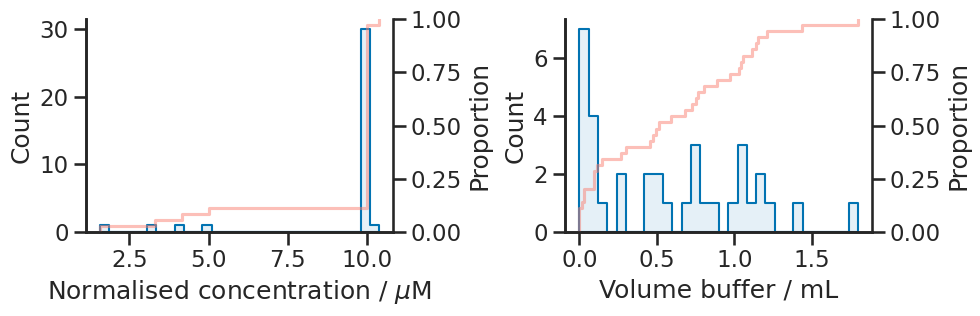

In [40]:
desired_conc = 10  # uM

df["buffer_vol"] = df.pooled_vol * (df.conc_uM - desired_conc) / desired_conc
df["buffer_vol"] = df.apply(correct_buffer, args=(2,), axis=1)
df["normed_conc_uM"] = df.conc_uM * df.pooled_vol / (df.pooled_vol + df.buffer_vol)

frac_correct = np.isclose(
    df.normed_conc_uM.to_list(), desired_conc, atol=0.05
).sum() / len(df)
print(f"{100 * frac_correct:.1f}% of wells will have the desired concentration.")

# Plot normalization statistics.
fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
ax = ax.reshape(-1)

for i, (k, v) in enumerate(
    {
        "normed_conc_uM": "Normalised concentration / $\mu$M",
        "buffer_vol": "Volume buffer / mL",
    }.items()
):

    sns.histplot(df[k], ax=ax[i], element="step", alpha=0.1, bins=30)
    sns.ecdfplot(df[k], ax=ax[i].twinx(), alpha=0.5, color="salmon")
    ax[i].spines["right"].set_visible(True)
    ax[i].set(xlabel=v)

plt.tight_layout()
#plt.savefig("normalization_results.png", dpi=300)
plt.show()

In [41]:
gen_ot2_script(
    df.dropna(),
    sec_instrument,
    normalize=True,
    #path="/home/ach94/projects/p05_peptide_ligase/e151_ligase_cowboy/cowboy/",
    separate_non_normed=False,
    template="/net/software/lab/cowboy/SEC_pool_and_norm_v3.py",
)

240808_sec_pool_and_norm.py contains transfers from 35 fractions to 35 destination wells
240808_sec_pool_and_norm.py contains transfers to 35 destination wells
[ ['1-P1-A5',], [200.20000000000016], 1, 'A1', 149.310],
[ ['1-P1-D6',], [200.20000000000016], 1, 'B1', 1052.973],
[ ['1-P1-A13',], [200.1999999999997], 1, 'A2', 92.035],
[ ['1-P1-D1',], [199.55000000000013], 1, 'B2', 767.097],
[ ['1-P1-A20',], [200.20000000000016], 1, 'A3', 0.000],
[ ['1-P1-E8',], [200.19999999999993], 1, 'B3', 1031.425],
[ ['1-P1-B23',], [200.19999999999993], 1, 'A4', 27.367],
[ ['1-P1-E15',], [199.55000000000013], 1, 'B4', 1150.943],
[ ['1-P1-B18',], [200.19999999999993], 1, 'A5', 751.841],
[ ['1-P1-E21',], [200.20000000000016], 1, 'B5', 496.032],
[ ['1-P1-B9',], [200.20000000000016], 1, 'A6', 117.157],
[ ['1-P1-F19',], [200.20000000000016], 1, 'B6', 1437.457],
[ ['1-P1-B2',], [200.19999999999993], 1, 'A7', 1141.446],
[ ['1-P1-F13',], [200.20000000000016], 1, 'B7', 0.000],
[ ['1-P1-C6',], [200.20000000000016]

## LEGACY FUNCTIONALITY: Save data to disk

The following two files will be generated:
- `.csv` file containing only the scalar entries of the dataframe.
- `.h5` file containing everything, including arrays (i.e. SEC traces, etc...).

In [35]:
def is_scalar(column):
    return all(isinstance(entry, (int, float, str)) for entry in column)


df[[col for col in df.columns if is_scalar(df[col])]].to_csv(f"{today}_expdata_df.csv")
df.to_hdf(f"{today}_expdata_df.h5", key="df", complevel=9)

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

## Legacy plots

In [ ]:
sns.boxplot(
    data=df,
    x="category",
    y="tot_yield",
    fliersize=0,
    color="white",
)

sns.swarmplot(
    data=df,
    x="category",
    y="tot_yield",
    alpha=0.8,
    edgecolor="k",
    linewidth=1,
    size=6,
)
plt.ylabel("Tot. yield / mg")
plt.tight_layout()
plt.savefig("yields_by_category.png", dpi=300)
plt.show()

In [ ]:
cat2col = {cat: "C" + str(i) for i, cat in enumerate(df.category.unique())}

g = sns.clustermap(
    df["Abs_norm_light"].to_list(),
    method="average",
    cmap="bone_r",
    col_cluster=False,
    row_colors=[cat2col[cat] for cat in df.category.to_list()],
    tree_kws={"lw": 1, "color": "grey"},
)

g.cax.remove()
plt.yticks([])

# X-axis
nlabels = 7
vmin, vmax = np.min(df.vol_light.min()), np.max(df.vol_light.max())
vol_labels = np.linspace(vmin, vmax, nlabels, dtype=float)
mw_labels = [Vel2MW(v) for v in vol_labels]
lbls = [f"{v:.2f}\n[{mw/1000:.0f}]" for v, mw in list(zip(vol_labels, mw_labels))]
plt.xticks(ticks=np.linspace(0, 100, nlabels), labels=lbls, rotation=0)

# Legend
handles = [Patch(edgecolor="k", facecolor=v) for v in cat2col.values()]
plt.legend(
    handles,
    cat2col.keys(),
    title="category",
    ncol=int(len(cat2col) / 2),
    bbox_to_anchor=(0.55, 0.92),
    bbox_transform=plt.gcf().transFigure,
    loc="upper center",
)

plt.xlabel("Retention vol. / mL\n[MW / kDa]")
plt.savefig("clustered_sec_traces.png", dpi=300)
plt.show()